# Steganograpy - using PIL and NumPy

## Hiding in Plain Sight

Steganograpy is the practice of hiding information in other images, audio, text, ... You can add hidden messages to pictures, hide a file within another file, ... Here we'll try to hide some information inside an image.

Images are essentially two dimentional lists of pixels, which in turn consist of three integer numbers in the range 0-255 that represent values for red, green and blue. The difference between a pixel with value rgb(230, 129, 200) and rgb(229, 129, 201) are virtually inperceptable. So we can leverage this and hide information in that least significant bits of each pixel.

To hide a message in an image a function is needed that **converts a string to a binary representation** and one that **embeds that data in the least significant bits of an image**. To reveal the message we need to be able to reverse this, so first a function will **extract the least significant bits** and the final step is to **convert them back into a string**. 

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

To convert text to binary and back I found a function on [StackOverflow](https://stackoverflow.com/questions/7396849/convert-binary-to-ascii-and-vice-versa) though it is a little hard to understand. So let's dissect the encode_text function step by step.

  * ```str.encode``` is used to turn the string into bytes
  * ```int.from_bytes``` now creates an integer number from those bytes. This works because in Python integer numbers can be arbitrarily large.
  * this number is converted into binary (e.g. 0b00101011010101010101010001... ) using ```bin()```
  * an array slice is used to remove the first two characters (0b)
  * ```zfill``` is used to make sure the output is a multiple of 8
  
To revert from a binary the padding and slicing can be omitted and the other steps need to be reversed.

  * ```int()``` is used to convert a binary representation back to an integer number, note the parameter 2
  * using the ```int.to_bytes``` this number is converted back to a list of bytes
  * ```str.decode``` converts bytes back to text
  
To check if this works a bit of *Lorem ipsum* is converted to binary and back.

In [2]:
# Convert the hidden message to bytes

def encode_text(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def decode_text(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'
        

hidden_message = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua."

encoded_text = encode_text(hidden_message)
decoded_text = decode_text(encoded_text)

print("encoded:", encoded_text)
print("decoded:", decoded_text)



encoded: 010011000110111101110010011001010110110100100000011010010111000001110011011101010110110100100000011001000110111101101100011011110111001000100000011100110110100101110100001000000110000101101101011001010111010000101100001000000110001101101111011011100111001101100101011000110111010001100101011101000111010101110010001000000110000101100100011010010111000001101001011100110110001101101001011011100110011100100000011001010110110001101001011101000010110000100000011100110110010101100100001000000110010001101111001000000110010101101001011101010111001101101101011011110110010000100000011101000110010101101101011100000110111101110010001000000110100101101110011000110110100101100100011010010110010001110101011011100111010000100000011101010111010000100000011011000110000101100010011011110111001001100101001000000110010101110100001000000110010001101111011011000110111101110010011001010010000001101101011000010110011101101110011000010010000001100001011011000110100101110001011101010110000100101110
decode

With functions to convert any text into binary and back, the code to bake that binary information into an image can be written. Here the [PIL](https://pillow.readthedocs.io/en/stable/) library is used to load the image, which is than turned into a one-dimensional list of all Red, Green and Blue values of the pixel in the image. 

A suffix <STOP> is added to the hidden message so when decoding the image it is clear where the message ends. This is then converted to binary. Next, a loop goes over all bits, and encodes them in the least significant bit of the flattened image. This is done by applying a binary mask (0b11111110) to the value to set the least significant bit to zero and then a binary *or* operation is used to set that value to the desired value. 
    
The clause ```ix < len(encoded_text) else value``` ensures that if that pixels in spots where hidden information isn't stored remain identical.
    
Finally, the one-dimensional array is turned back into a 2D image with 3 color channels and exported as PIL image. To test this, and image ```pear.png``` is loaded, a Hello World message inserted and the image written to disk again. Make sure that when saving the image, a lossless file format is used. JPEG files are compressed in a way that some minor details are lost, this could remove the hidden content, so here PNG is used. 


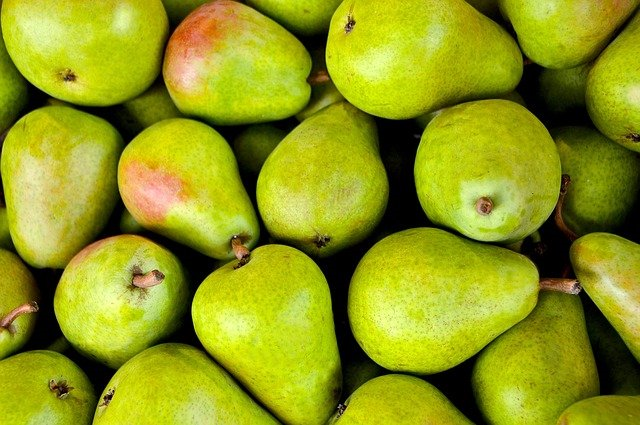

In [3]:
# Store image shape and flatten the image to a one-dimensional array of numbers

def encode_in_image(filename, text_message):
    # Open the image, store the shape and convert to one-dimensional list
    input_im = Image.open(filename, 'r').convert("RGB")
    image_shape = np.asarray(input_im).shape
    flat_array = np.asarray(input_im).flatten()

    # Encode the message and add prefix
    encoded_text = encode_text(text_message + "<STOP>")
    
    # Enter message in the least significant bit where necessary
    encoded_array = [
        (0b11111110 & value) | int(encode_bit) if ix < len(encoded_text) else value
        for ix, (encode_bit, value) in enumerate(zip(encoded_text.ljust(len(flat_array), '0'), flat_array))]

    # Turn encoded array into image and return
    encoded_im = np.array(encoded_array).reshape(image_shape)    
    return Image.fromarray(np.uint8(encoded_im)).convert('RGB')



encoded_im = encode_in_image('pears.png', "Hello World")
encoded_im.save('pears_with_hidden_message.png')
encoded_im

Cool, our image looks identical to the input image. By eye the minor differences are imperceivable. One last function to add, to extract the hidden message from an image. This is fairly simple, after te image is loaded it is flattened into a one-dimensional array again. For each value the least significant bit is extracted using a bit mask. These values are joined into a single string, which is decoded using the ```decode_text``` function. Finally, we need to break the decoded text on the suffix <STOP>, beyond that suffix there is no information encoded and there will be a lot of jibberish returned. A simple ```split()``` does that trick.
    
Finally, we run that code on the image where a message was embedded ... and voila, our original message comes out again.

In [4]:
def extract_from_image(filename):
    # Open image
    encoded_im = np.asarray(Image.open(filename, 'r').convert("RGB"))

    # Extract least significant bits from flat (one-dimensional) image
    extracted_bits = [str(0b00000001 & value) for value in encoded_im.flatten()]

    # Join bits together, decode and split at <STOP>
    extracted_bits = ''.join(extracted_bits)
    return decode_text(extracted_bits, errors='replace').split('<STOP>')[0]
    
extract_from_image('pears_with_hidden_message.png')

'Hello World'